In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
# regla de Sturges para determinar el número de bins en un histograma
def Sturges_rule(n):
    return int(np.ceil(1 + np.log2(n)))
# funcion de espacios para visualización
def espacios(n):
    print("\n"*n)

def mean_non_zero(series):
    return series[series > 0].mean()
# Función para convertir un mes en texto a un número
def mes_a_numero(mes):
    meses = {
        'Enero': 1,
        'Febrero': 2,
        'Marzo': 3,
        'Abril': 4,
        'Mayo': 5,
        'Junio': 6,
        'Julio': 7,
        'Agosto': 8,
        'Septiembre': 9,
        'Octubre': 10,
        'Noviembre': 11,
        'Diciembre': 12,
    }
    return meses[mes]

In [3]:
conn = sqlite3.connect('sensores.db')
Datos_unificados=pd.read_sql_query("SELECT * FROM datos_unificados", conn)
conn.close()
Datos_unificados["FechaHora"]=pd.to_datetime(Datos_unificados["FechaHora"])

In [4]:
#En esta sección creamos las variables adicionales que vamos a analizar para la PTAP
Datos_unificados["Remoción_Turbiedad"]=Datos_unificados["Turbiedad_cruda"]-Datos_unificados["Turbiedad_distribución"]
Datos_unificados["fracción_Turbiedad"]=Datos_unificados["Turbiedad_distribución"]/Datos_unificados["Turbiedad_cruda"]
Datos_unificados["Cloro_Total"]=Datos_unificados["Cloro2"]+Datos_unificados["Cloro1"]
Datos_unificados["Remocion_Manganeso"]=Datos_unificados["Manganeso_cruda"]-Datos_unificados["Manganeso_distribución"]

In [5]:
# analisis por clustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [6]:
columnas_a_evaluar = [
    "Turbiedad_cruda",
    "Color_agua_Natural",
    # "pH_cruda",
    "Polimero"
]
columna_objetivo = "Sulfato"
datos_filtrados_sulfato = Datos_unificados.copy().dropna(subset=[columna_objetivo])

for columna in columnas_a_evaluar:
    datos_filtrados_sulfato = datos_filtrados_sulfato.dropna(subset=[columna])
    
x = datos_filtrados_sulfato[columnas_a_evaluar]
y = datos_filtrados_sulfato[columna_objetivo]

y_unicos=y.unique()
y_unicos.sort()


y = y.apply(lambda x: np.where(y_unicos == x)[0][0])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
clasificador = KNeighborsClassifier(n_neighbors=3,metric='euclidean')
clasificador.fit(x_train_scaled, y_train)
y_pred = clasificador.predict(x_test_scaled)






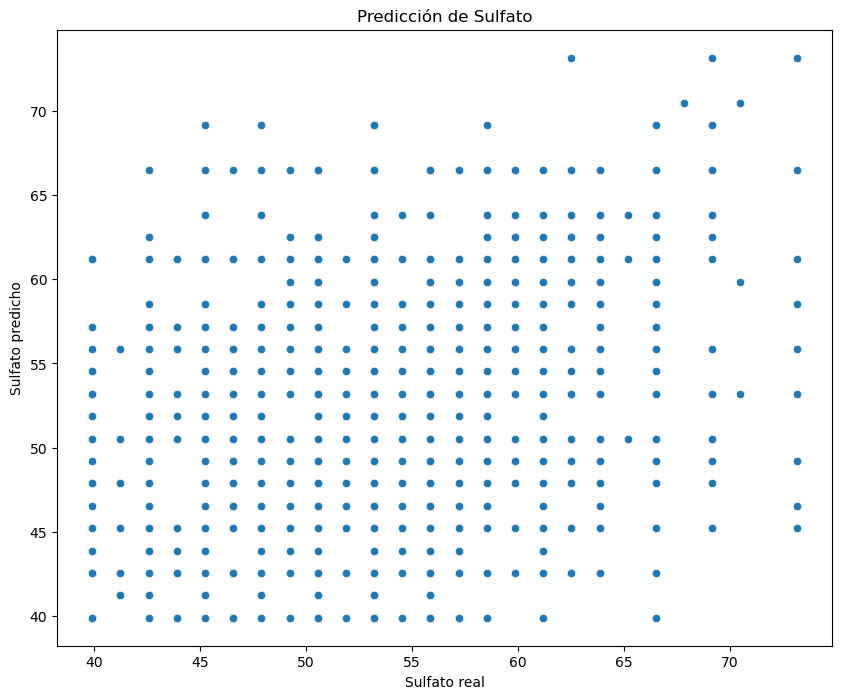

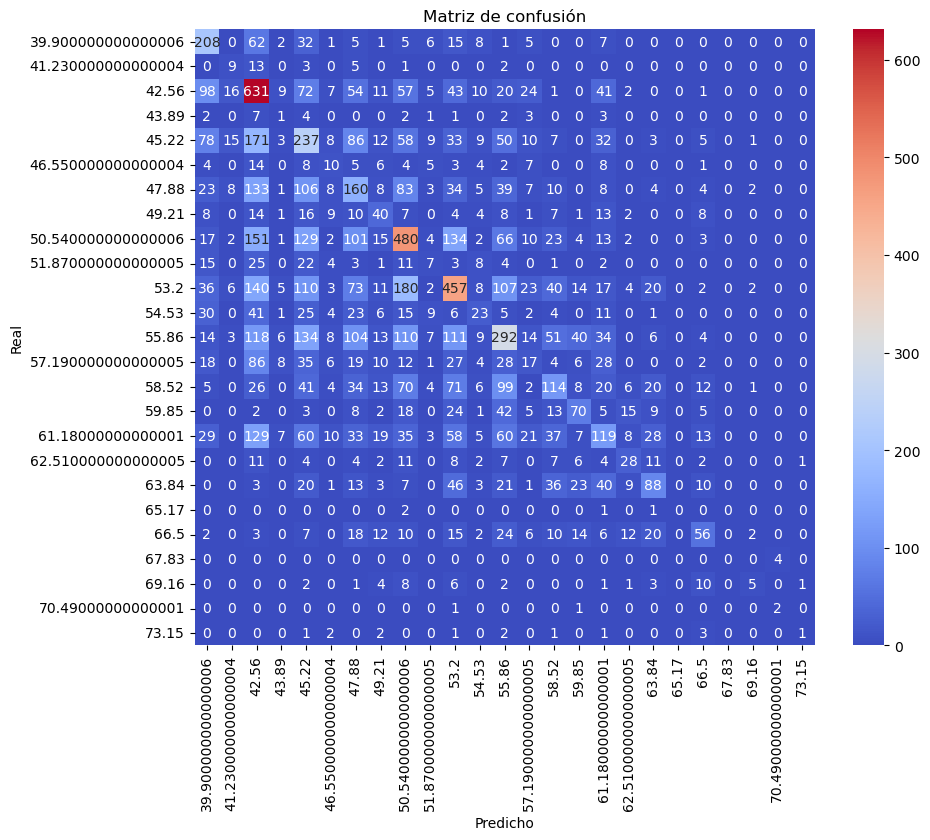

In [7]:
matriz_confusion = confusion_matrix(y_test, y_pred)
matriz_confusion = pd.DataFrame(matriz_confusion, index=y_unicos, columns=y_unicos)

y_pred = y_unicos[y_pred]
y_test = y_unicos[y_test]
matriz_resultado=pd.DataFrame({'Real':y_test,'Predicho':y_pred})

plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Sulfato real')
plt.ylabel('Sulfato predicho')
plt.title('Predicción de Sulfato')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_confusion, annot=True, cmap='coolwarm', fmt='d')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()



In [8]:
indices=matriz_confusion.index
columnas=matriz_confusion.columns

# print(matriz_confusion.loc[indices[0],2].sum())


In [9]:
for indice in range(len(y_unicos)):
    valor_acumulado=0
    for columna in range(len(y_unicos)):
        valor_acumulado+=matriz_confusion.iloc[indice,columna]*abs(y_unicos[indice]-y_unicos[columna])
        # if indice==0:
        #     # print(valor_acumulado)
        #     # print(matriz_confusion.iloc[indice,columna]*abs(y_unicos[indice]-y_unicos[columna]))
        #     print(matriz_confusion.iloc[indice,columna])
    matriz_confusion.loc[indices[indice],"SumaProducto"]=valor_acumulado
    # print(matriz_confusion.iloc[indice,0:(len(y_unicos)-1)].sum())
    valor_acumulado=valor_acumulado/matriz_confusion.iloc[indice,0:(len(y_unicos))].sum()
    
    matriz_confusion.loc[indices[indice],"Error"]=valor_acumulado*100/y_unicos[indice]

In [10]:
print(matriz_confusion)

       39.9  41.23  42.56  43.89  45.22  46.55  47.88  49.21  50.54  51.87  \
39.90   208      0     62      2     32      1      5      1      5      6   
41.23     0      9     13      0      3      0      5      0      1      0   
42.56    98     16    631      9     72      7     54     11     57      5   
43.89     2      0      7      1      4      0      0      0      2      1   
45.22    78     15    171      3    237      8     86     12     58      9   
46.55     4      0     14      0      8     10      5      6      4      5   
47.88    23      8    133      1    106      8    160      8     83      3   
49.21     8      0     14      1     16      9     10     40      7      0   
50.54    17      2    151      1    129      2    101     15    480      4   
51.87    15      0     25      0     22      4      3      1     11      7   
53.20    36      6    140      5    110      3     73     11    180      2   
54.53    30      0     41      1     25      4     23      6    

10.847909200759608


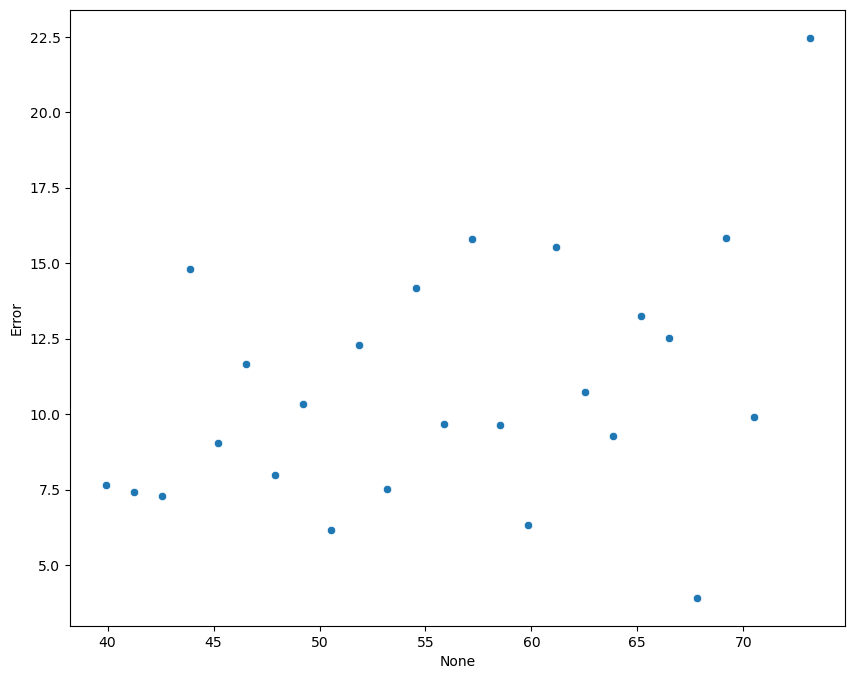

In [11]:
print(matriz_confusion["Error"].mean())
plt.figure(figsize=(10, 8))
sns.scatterplot(x=matriz_confusion.index, y=matriz_confusion["Error"])
plt.show()
